# Linear Similarity 

This notebooks explores the linear similarity (dot product) across different timestamps from the same variable with a configuration of the variable that relates highly to heatwaves (in the same timestamp).

In [1]:
import pandas as pd

import os
import numpy as np
import sys
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from IndexDrivers import calculate_anomalies, Index, AnomaliesIndex

c:\Users\marti\Desktop\data\hw_extra


In [ ]:
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
# data_msl = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")
# data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")

## Advection Configuration

In [4]:
data_850 = calculate_anomalies(data_850, [1980,2010], std=True)

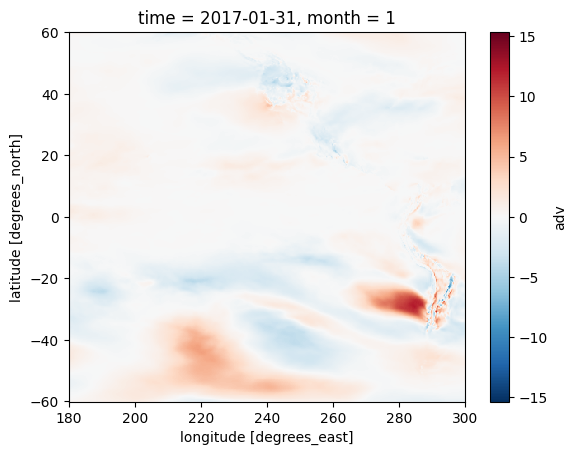

In [5]:
timestamp_hw = "2017-01"
data_850["adv"] = -1*data_850.u*data_850.t
data_850.adv.sel(time=timestamp_hw).plot()

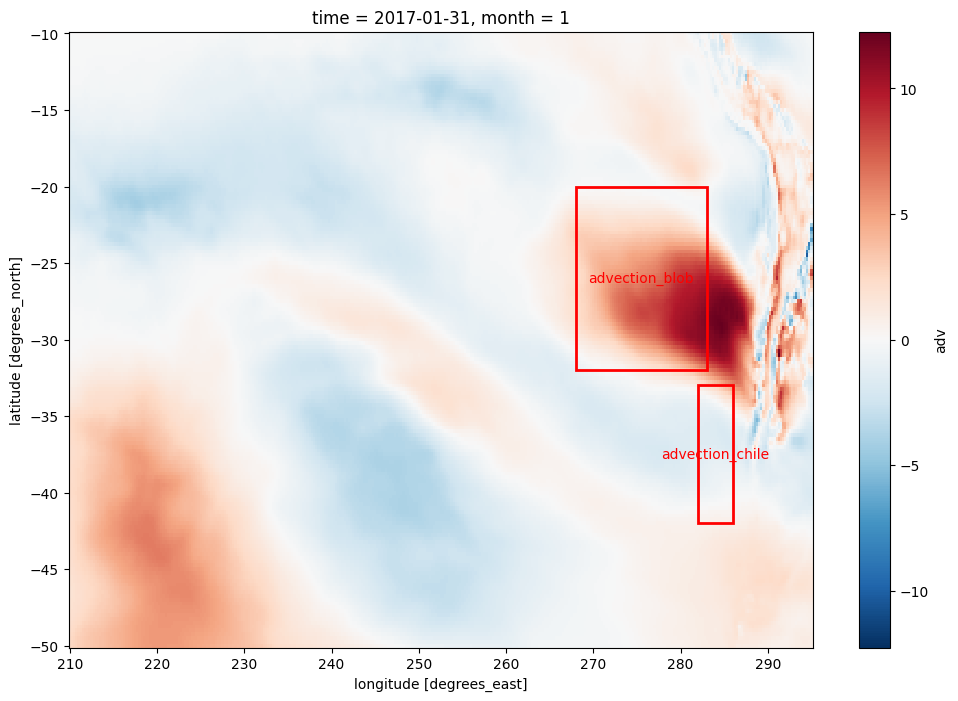

In [6]:
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_850.sel(longitude=slice(210,295), latitude=slice(-50,-10), time="2017-01").adv.plot(ax=ax)

for box_id, coords in boxes_chile_adv.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [7]:
box = boxes_chile_adv["advection_blob"]
adv_data = data_850.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))

In [8]:
b = adv_data.sel(time=timestamp_hw).adv.to_numpy().reshape(adv_data.sizes["latitude"], adv_data.sizes["longitude"])

In [9]:
vector_hw = b.flatten()

In [10]:
timeserie_blob = []
for time_element in data_850.adv:
    box = boxes_chile_adv["advection_blob"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = b_data.to_numpy().reshape(b_data.sizes["latitude"], b_data.sizes["longitude"])
    timeserie_blob.append(np.dot(vector_hw, element.flatten()))

In [11]:
high_hws_dates = ["2015-03-01", "2016-09-01", "1997-08-01", "2017-02-01", "2019-02-01", "2014-08-01"]
low_hws_date = ["2000-05-01", "1990-11-01", "2001-05-01", "1975-05-01"]

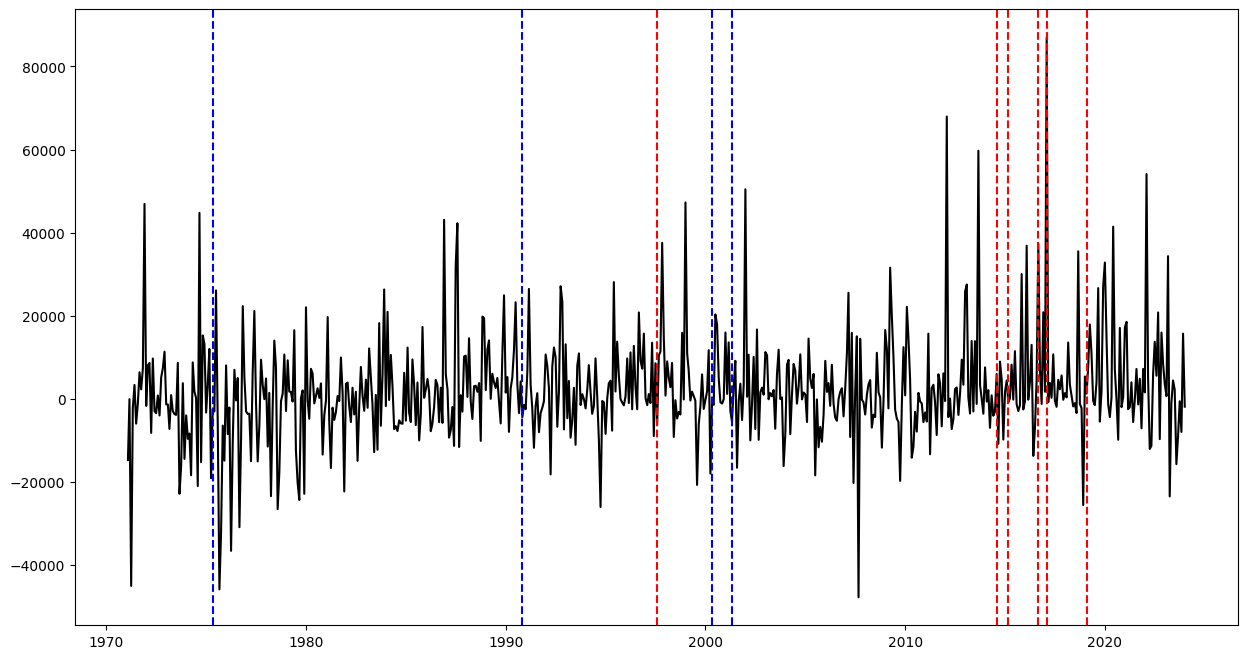

In [12]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_850.time, timeserie_blob, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [13]:
df = data_850.time.to_dataframe()

In [14]:
df["adv_index"] = timeserie_blob
df = df.drop(columns="time")
df = df[(df.index.year >= 1971) & (df.index.year <=2022)]
df.index = df.index.to_numpy().astype('datetime64[M]')  # Set the index as first day of the month
df.index.name = "Date"
df.drop(columns="month", inplace=True)
df

,adv_index
Date,
1971-01-01,-14703.490234
1971-02-01,-47.497456
1971-03-01,-44968.914062
1971-04-01,-2185.971191
1971-05-01,3365.131104
...,...
2022-08-01,20808.701172
2022-09-01,-9672.411133
2022-10-01,15979.045898


In [15]:
adv_index = Index(data_850, ["ADV"], boxes_chile_adv["advection_blob"])
adv_index.set_index(df)

In [16]:
box = "|".join(str(x) for x in boxes_chile_adv["advection_blob"])
data = f"normalized,ADV,{box},1972-2024,1971-2022"
adv_index.index_df_to_parquet(data, "data/my_indices/","data/my_indices/metadata.csv")

Saved


'89b253da'

In [17]:
def is_month(month, n):
    return month == n

In [18]:
timeserie_blob_seasons = {}
normalized = data_850.adv
seasons = {i: normalized.sel(time=is_month(normalized['time.month'], i)) for i in range(1,13)}
for season, datas in seasons.items():
    timeserie = []
    for time_element in datas:
        box = boxes_chile_adv["advection_blob"]
        data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        element = data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"])
        timeserie.append(np.dot(vector_hw, element.flatten()))
    timeserie_blob_seasons[season] = timeserie

In [19]:
hws_dates = {1: ['2016-01-01', '2017-01-01', '2013-01-01'],
             2: ['2020-02-01', '2005-02-01', '2008-02-01'],
             3: ['2015-03-01', '2009-03-01', '2012-03-01'],
             4: ['2009-04-01', '2017-04-01', '2015-04-01'],
             5: ['2020-05-01', '1998-05-01', '2023-05-01'],
             6: ['1987-06-01', '2015-06-01', '1991-06-01'],
             7: ['2023-07-01', '2006-07-01', '1996-07-01'],
             8: ['1997-08-01', '2001-08-01', '2003-08-01'],
             9: ['2016-09-01', '2008-09-01', '1996-09-01'],
             10: ['1983-10-01', '1989-10-01', '2014-10-01'],
             11: ['2019-11-01', '2008-11-01', '2022-11-01'],
             12: ['2021-12-01', '2001-12-01', '2013-12-01']}

non_hws_dates = {1: ['1975-01-01', '1974-01-01', '1981-01-01'],
             2: ['1975-02-01', '1972-02-01', '1986-02-01'],
             3: ['1975-03-01', '1972-03-01', '1985-03-01'],
             4: ['1975-04-01', '1973-04-01', '2000-04-01'],
             5: ['2000-05-01', '2001-05-01', '1975-05-01'],
             6: ['2007-06-01', '1975-06-01', '2011-06-01'],
             7: ['1971-07-01', '2017-07-01', '2007-07-01'],
             8: ['2017-08-01', '2007-08-01', '1971-08-01'],
             9: ['2007-09-01', '1987-09-01', '2017-09-01'],
             10: ['2023-10-01', '2017-10-01', '1987-10-01'],
             11: ['1990-11-01', '2017-11-01', '1973-11-01'],
             12: ['1975-12-01', '1973-12-01', '1974-12-01']}

Text(0.5, 0.98, 'ADV blob by season and HW months')

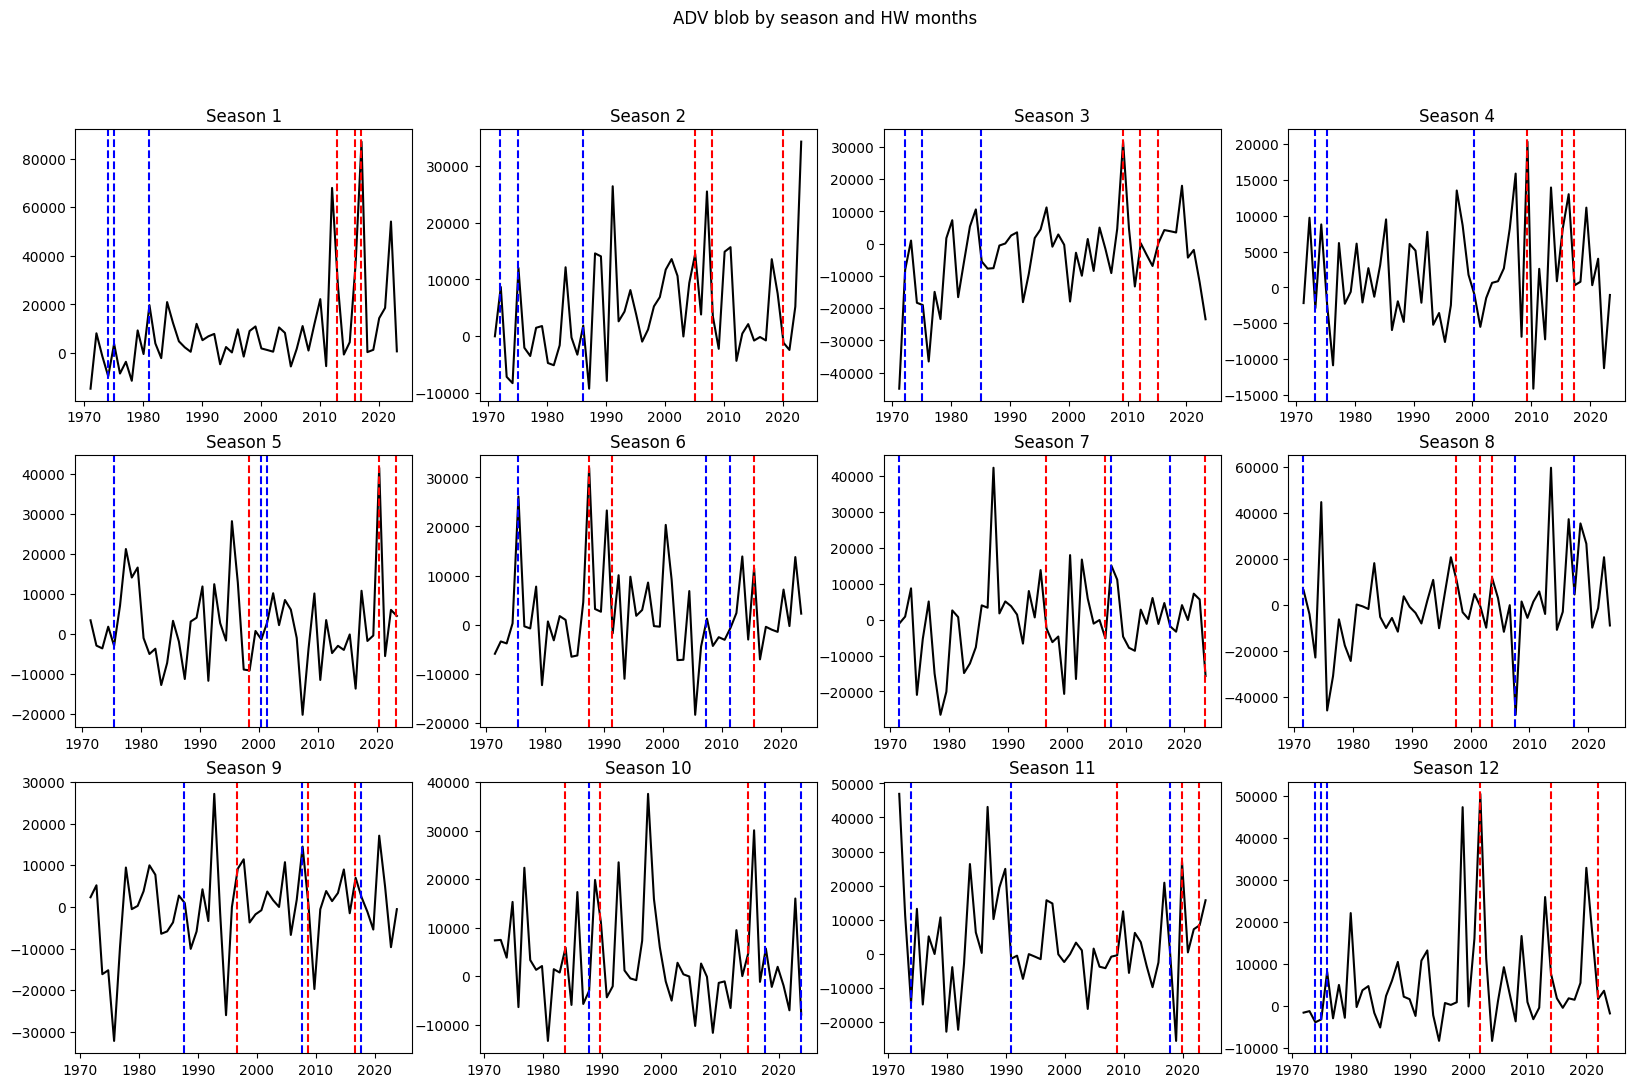

In [20]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_blob_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, ts, c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')

fig.suptitle("ADV blob by season and HW months")

Text(0.5, 0.98, 'Absolute ADV blob by season and HW months')

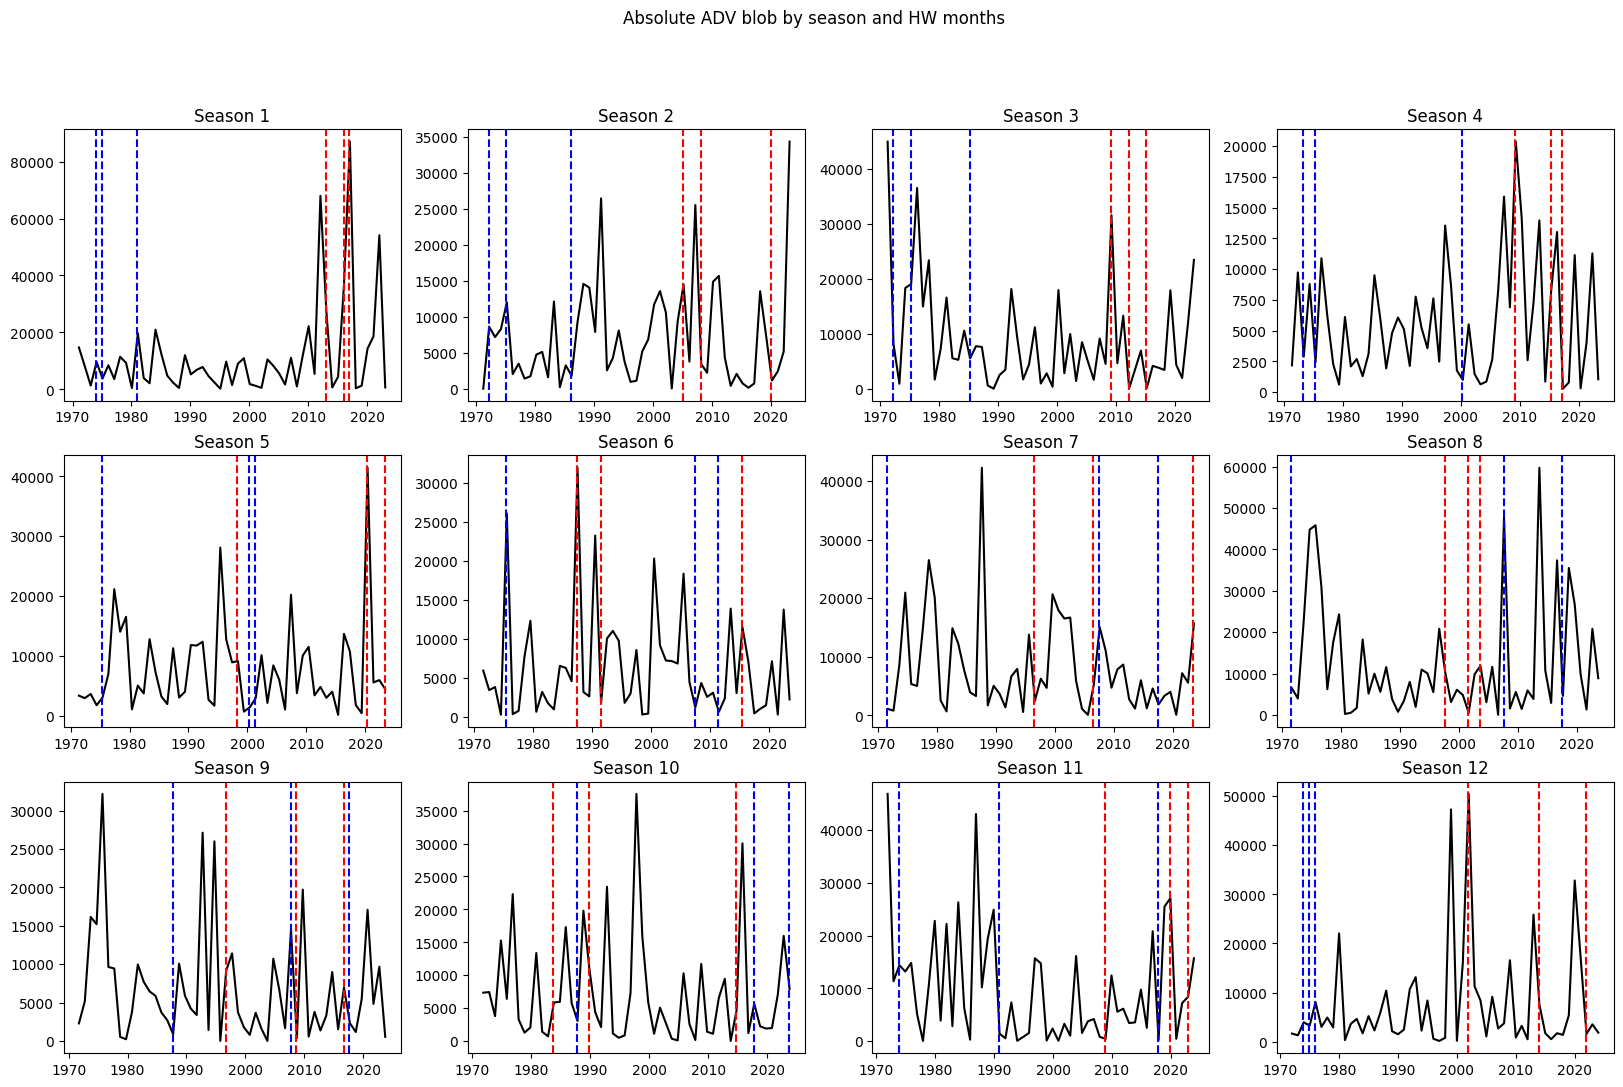

In [21]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_blob_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, np.abs(ts), c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')
fig.suptitle("Absolute ADV blob by season and HW months")

In [22]:
box = boxes_chile_adv["advection_chile"]
adv_data = data_850.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))

In [23]:
b = adv_data.sel(time=timestamp_hw).adv.to_numpy().reshape(adv_data.sizes["latitude"], adv_data.sizes["longitude"])

In [24]:
vector_hw = b.flatten()

In [25]:
timeserie_chile = []
for time_element in data_850.adv:
    box = boxes_chile_adv["advection_chile"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = b_data.to_numpy().reshape(b_data.sizes["latitude"], b_data.sizes["longitude"])
    timeserie_chile.append(np.dot(vector_hw, element.flatten()))

In [26]:
high_hws_dates = ["2015-03-01", "2016-09-01", "1997-08-01", "2017-02-01", "2019-02-01", "2014-08-01"]
low_hws_date = ["2000-05-01", "1990-11-01", "2001-05-01", "1975-05-01"]

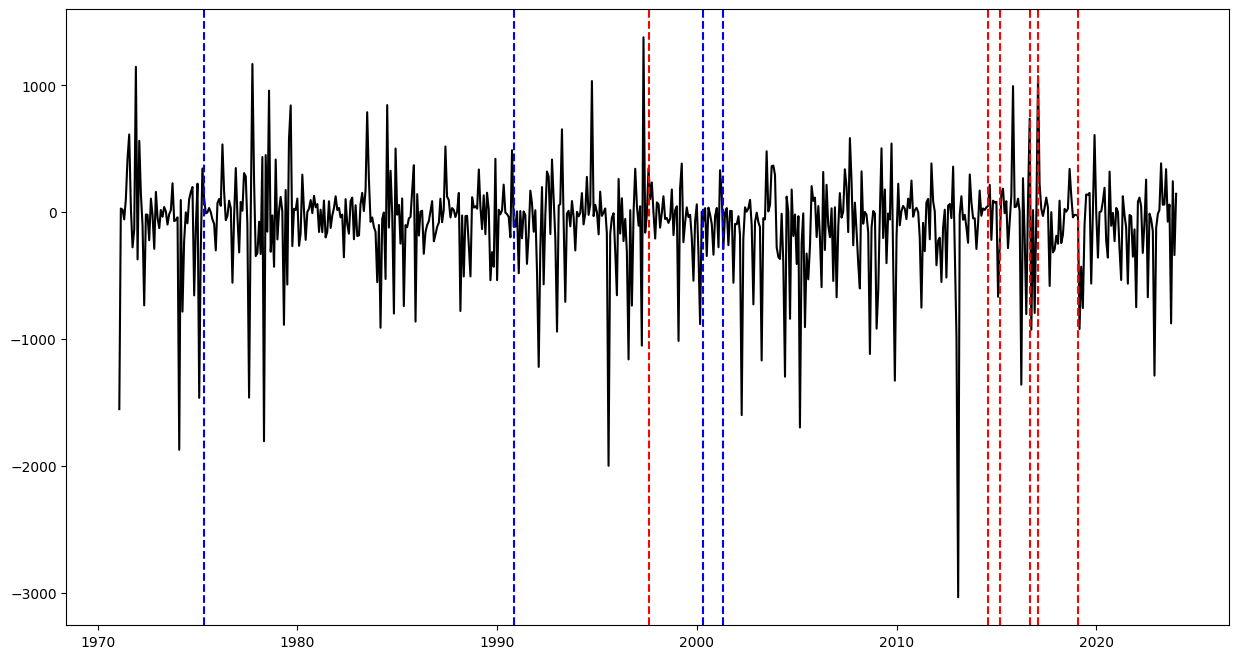

In [27]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_850.time, timeserie_chile, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [28]:
df = data_850.time.to_dataframe()

In [29]:
df["adv_index"] = timeserie_chile
df = df.drop(columns="time")
df = df[(df.index.year >= 1971) & (df.index.year <=2022)]
df.index = df.index.to_numpy().astype('datetime64[M]')  # Set the index as first day of the month
df.index.name = "Date"
df.drop(columns="month", inplace=True)
df

,adv_index
Date,
1971-01-01,-1552.104004
1971-02-01,28.877777
1971-03-01,20.723490
1971-04-01,-56.749893
1971-05-01,105.009048
...,...
2022-08-01,-11.900213
2022-09-01,-56.497807
2022-10-01,-150.026672


In [30]:
adv_index = Index(data_850, ["ADV"], boxes_chile_adv["advection_chile"])
adv_index.set_index(df)

In [31]:
box = "|".join(str(x) for x in boxes_chile_adv["advection_chile"])
data = f"normalized,ADV,{box},1972-2024,1971-2022"
adv_index.index_df_to_parquet(data, "data/my_indices/","data/my_indices/metadata.csv")

Saved


'5dc57ac1'

In [32]:
def is_month(month, n):
    return month == n

In [33]:
timeserie_chile_seasons = {}
normalized = data_850.adv
seasons = {i: normalized.sel(time=is_month(normalized['time.month'], i)) for i in range(1,13)}
for season, datas in seasons.items():
    timeserie = []
    for time_element in datas:
        box = boxes_chile_adv["advection_chile"]
        data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        element = data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"])
        timeserie.append(np.dot(vector_hw, element.flatten()))
    timeserie_chile_seasons[season] = timeserie

In [34]:
hws_dates = {1: ['2016-01-01', '2017-01-01', '2013-01-01'],
             2: ['2020-02-01', '2005-02-01', '2008-02-01'],
             3: ['2015-03-01', '2009-03-01', '2012-03-01'],
             4: ['2009-04-01', '2017-04-01', '2015-04-01'],
             5: ['2020-05-01', '1998-05-01', '2023-05-01'],
             6: ['1987-06-01', '2015-06-01', '1991-06-01'],
             7: ['2023-07-01', '2006-07-01', '1996-07-01'],
             8: ['1997-08-01', '2001-08-01', '2003-08-01'],
             9: ['2016-09-01', '2008-09-01', '1996-09-01'],
             10: ['1983-10-01', '1989-10-01', '2014-10-01'],
             11: ['2019-11-01', '2008-11-01', '2022-11-01'],
             12: ['2021-12-01', '2001-12-01', '2013-12-01']}

non_hws_dates = {1: ['1975-01-01', '1974-01-01', '1981-01-01'],
             2: ['1975-02-01', '1972-02-01', '1986-02-01'],
             3: ['1975-03-01', '1972-03-01', '1985-03-01'],
             4: ['1975-04-01', '1973-04-01', '2000-04-01'],
             5: ['2000-05-01', '2001-05-01', '1975-05-01'],
             6: ['2007-06-01', '1975-06-01', '2011-06-01'],
             7: ['1971-07-01', '2017-07-01', '2007-07-01'],
             8: ['2017-08-01', '2007-08-01', '1971-08-01'],
             9: ['2007-09-01', '1987-09-01', '2017-09-01'],
             10: ['2023-10-01', '2017-10-01', '1987-10-01'],
             11: ['1990-11-01', '2017-11-01', '1973-11-01'],
             12: ['1975-12-01', '1973-12-01', '1974-12-01']}

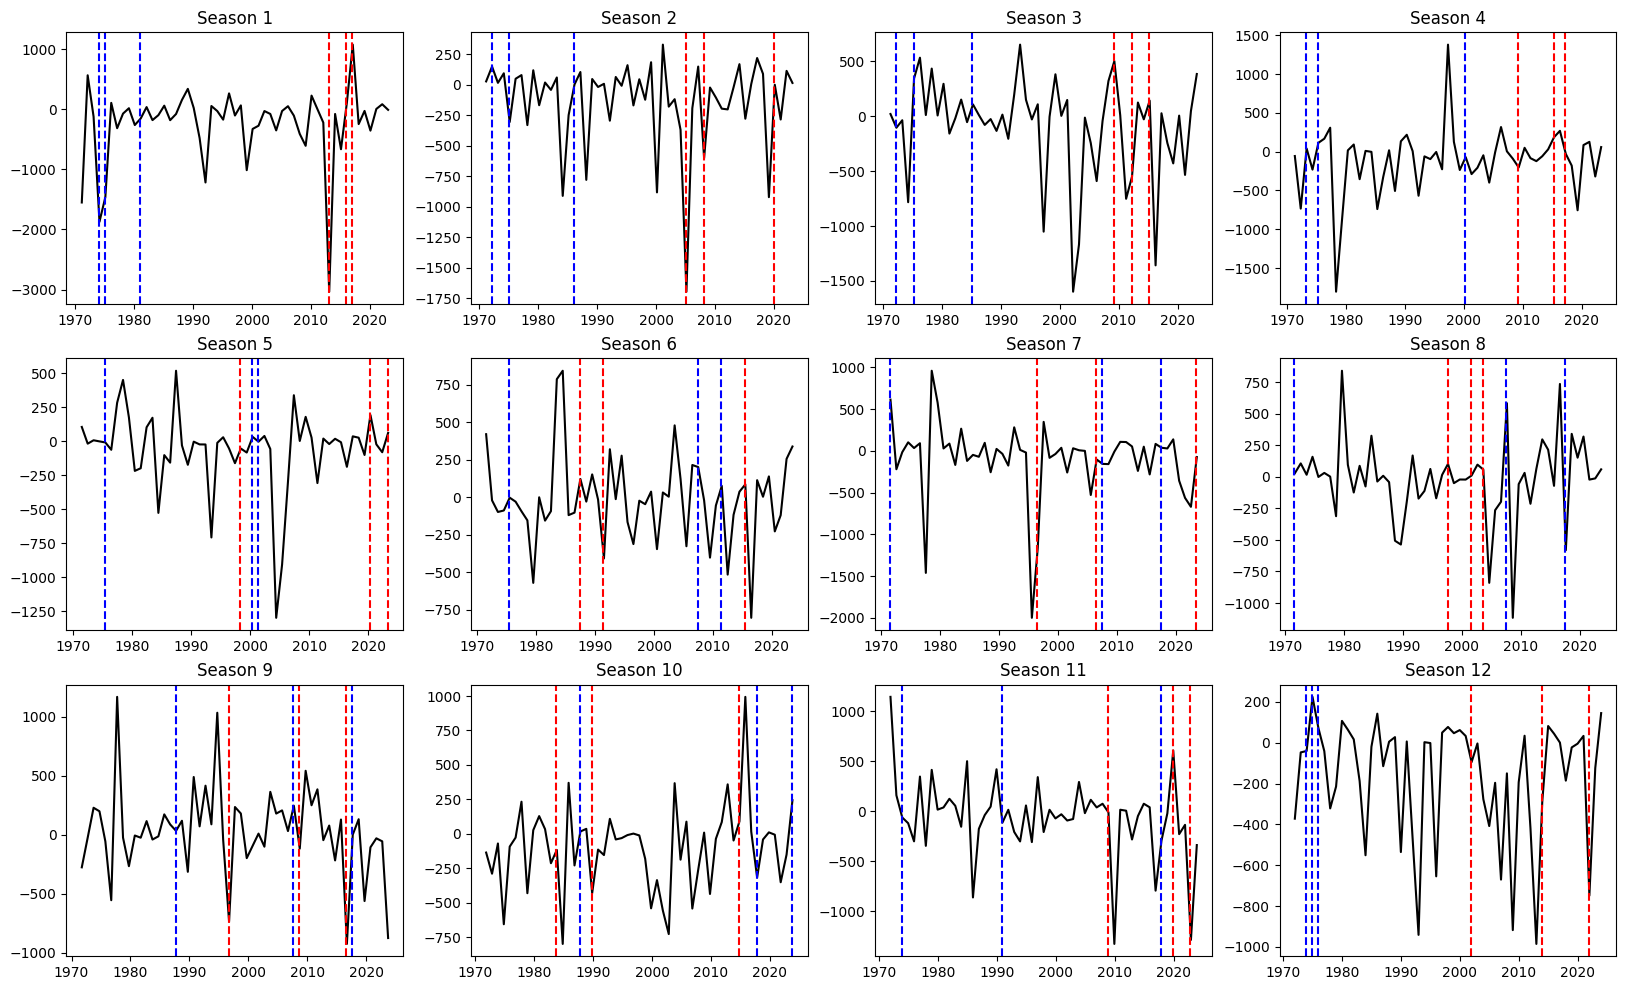

In [35]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_chile_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, ts, c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')

What if we check on absolute value? Apparently peaks/valleys are related to high hws months

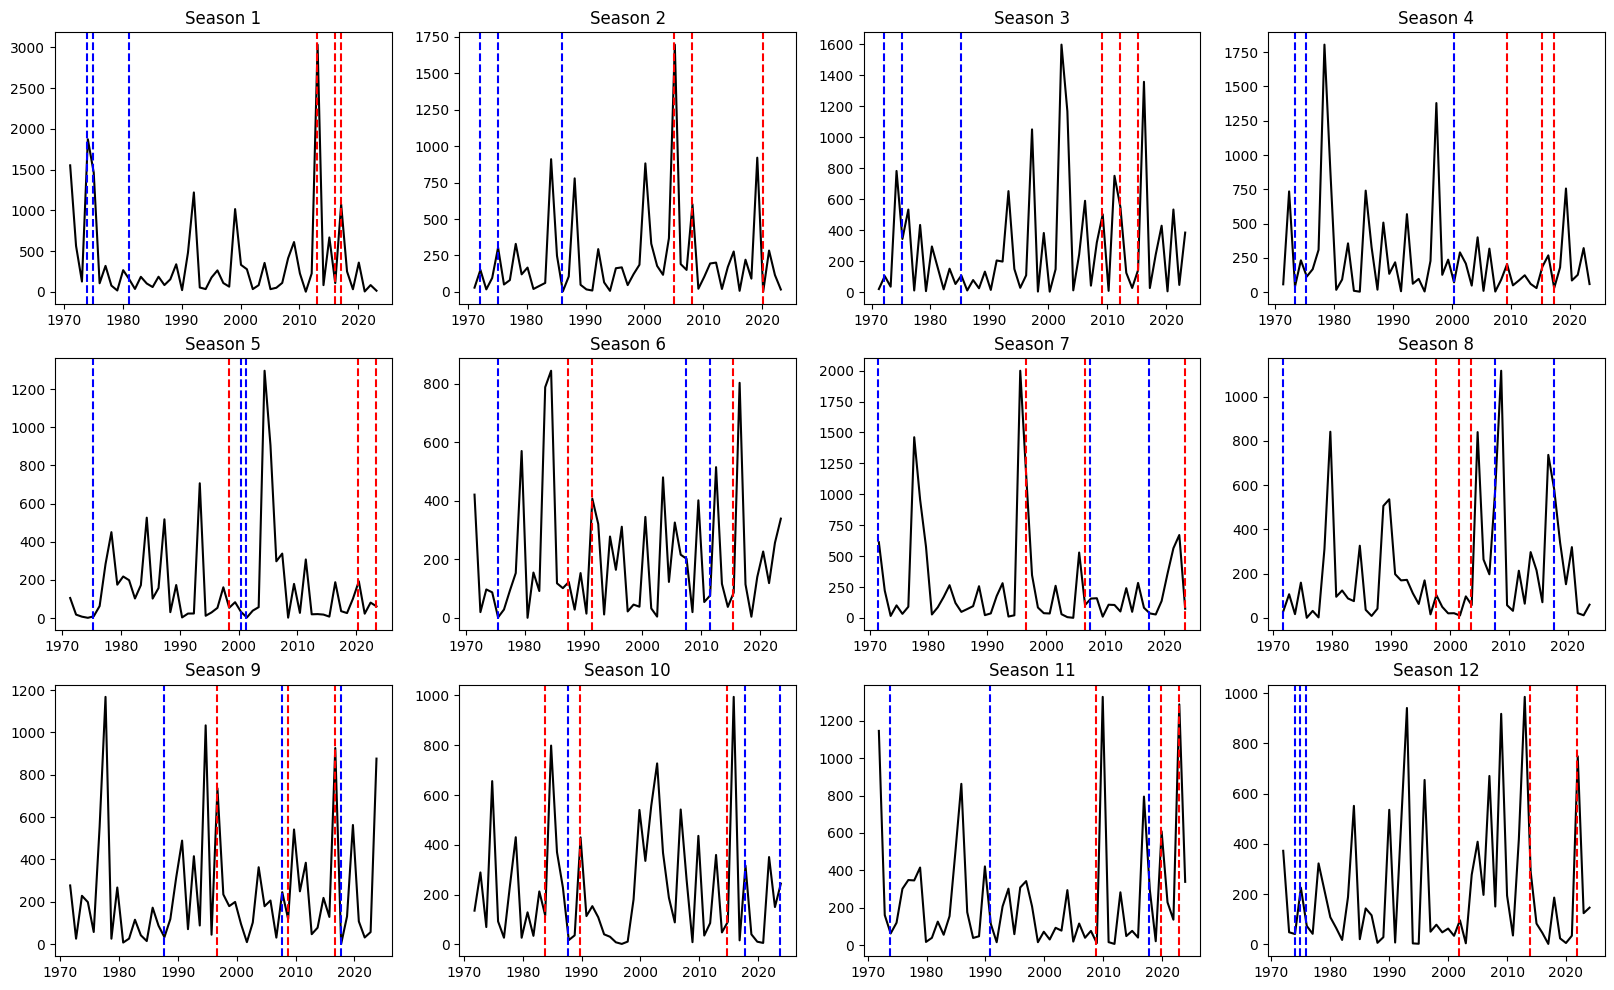

In [36]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_chile_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, np.abs(ts), c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')

## Check anom vs dot and correlations with HWs indices

In [37]:
advection_indices = [AnomaliesIndex(data_850, [1972,2022], reference_period=[1980,2010], variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(data_850, [1972,2022], reference_period=[1980,2010], variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]

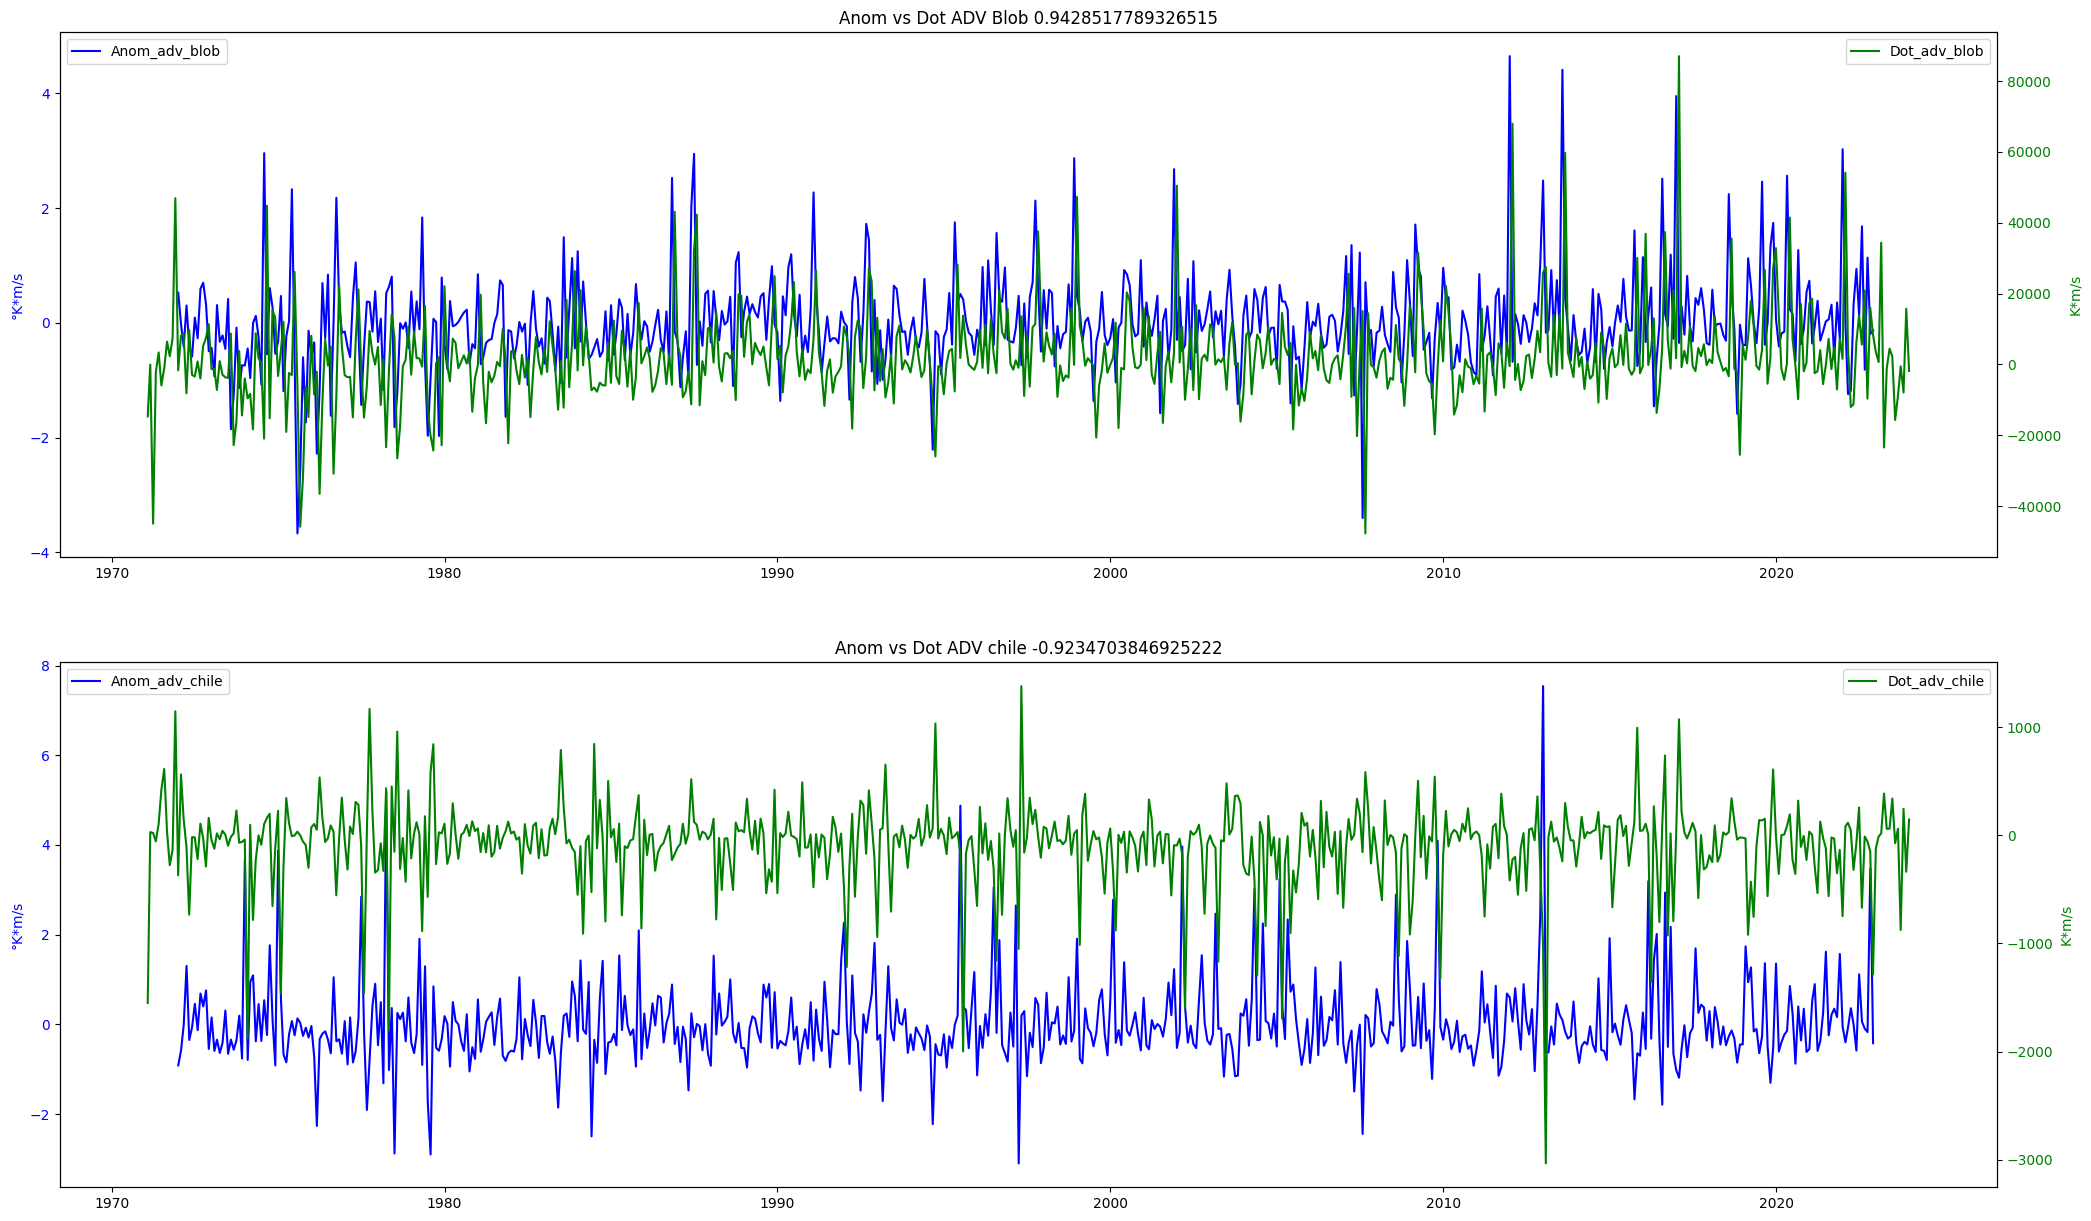

In [38]:
fig, ax1 = plt.subplots(2, 1, figsize=(25, 15))

ax1 = ax1.flatten()

index1_era5 = advection_indices[1].get_index("ADV")
index2_era5 = timeserie_blob

# Plot first series
ax1[0].plot(index1_era5.index, index1_era5["adv"], color='blue', label='Anom_adv_blob')
ax1[0].set_ylabel('°K*m/s', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(data_850.time, index2_era5, color='green', label='Dot_adv_blob')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

corr = np.corrcoef(index1_era5["adv"], timeserie_blob[12:-12])[0,1]
ax1[0].set_title(f"Anom vs Dot ADV Blob {corr}")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_era5 = advection_indices[0].get_index("ADV")
index2_era5 = timeserie_chile

# Plot first series
ax1[1].plot(index1_era5.index, index1_era5["adv"], color='blue', label='Anom_adv_chile')
ax1[1].set_ylabel('°K*m/s', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(data_850.time, index2_era5, color='green', label='Dot_adv_chile')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

corr = np.corrcoef(index1_era5["adv"], timeserie_chile[12:-12])[0,1]
ax1[1].set_title(f"Anom vs Dot ADV chile {corr}")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

In [39]:
hwis = pd.read_csv("data/local_data/monthly/HWs_chile_central.csv")
hwis["Date"] = pd.to_datetime(hwis["Date"],format='%Y-%m')
hwis.set_index('Date', inplace=True)

In [40]:
hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >=1972)]
hwis["anom_adv_blob"] = advection_indices[1].get_index("ADV")["adv"]
hwis["anom_adv_chile"] = advection_indices[0].get_index("ADV")["adv"]
hwis["dot_adv_blob"] = timeserie_blob[12:-12]
hwis["dot_adv_chile"] = timeserie_chile[12:-12]
hwis


,HWN,HWF,HWD,HWM,HWA,anom_adv_blob,anom_adv_chile,dot_adv_blob,dot_adv_chile
Date,,,,,,,,,
1972-01-01,0.1,0.3,0.3,0.451728,0.981709,0.525789,-0.917255,8107.849121,562.475647
1972-02-01,0.1,0.3,0.3,0.129245,0.199264,-0.032480,-0.577762,8668.342773,150.944244
1972-03-01,0.0,0.0,0.0,0.000000,0.000000,-0.415328,-0.017425,-8159.018555,-104.485443
1972-04-01,0.0,0.0,0.0,0.000000,0.000000,0.303330,1.301644,9730.250000,-734.223694
1972-05-01,0.1,0.3,0.3,0.090801,0.141019,-0.417260,-0.349298,-2953.427002,-17.844849
...,...,...,...,...,...,...,...,...,...
2022-08-01,0.4,1.2,1.2,0.802602,1.296802,1.681604,0.058647,20808.701172,-11.900213
2022-09-01,0.7,3.0,3.0,1.743964,2.930906,-0.815004,-0.098593,-9672.411133,-56.497807
2022-10-01,0.5,1.5,1.2,1.331460,2.364624,1.137413,-0.173696,15979.045898,-150.026672


In [41]:
hwis.corr().style.background_gradient(cmap='coolwarm').format("{:.3f}")

,HWN,HWF,HWD,HWM,HWA,anom_adv_blob,anom_adv_chile,dot_adv_blob,dot_adv_chile
HWN,1.000,0.977,0.944,0.877,0.911,0.141,0.094,0.161,-0.033
HWF,0.977,1.000,0.968,0.853,0.894,0.126,0.084,0.152,-0.027
HWD,0.944,0.968,1.000,0.882,0.902,0.107,0.029,0.124,0.023
HWM,0.877,0.853,0.882,1.000,0.983,0.112,0.054,0.115,-0.006
HWA,0.911,0.894,0.902,0.983,1.000,0.129,0.072,0.136,-0.020
anom_adv_blob,0.141,0.126,0.107,0.112,0.129,1.000,0.171,0.943,-0.022
anom_adv_chile,0.094,0.084,0.029,0.054,0.072,0.171,1.000,0.171,-0.923
dot_adv_blob,0.161,0.152,0.124,0.115,0.136,0.943,0.171,1.000,-0.012
dot_adv_chile,-0.033,-0.027,0.023,-0.006,-0.020,-0.022,-0.923,-0.012,1.000
